In [1]:
!pip install opendatasets
!pip install pandas

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, classification_report, confusion_matrix
import transformers
from transformers import AutoModel, BertTokenizerFast, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from torch.optim import AdamW

device = torch.device("cpu")

In [3]:
import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/datasets/kashishparmar02/social-media-sentiments-analysis-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: julfiqureantor
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/kashishparmar02/social-media-sentiments-analysis-dataset


100%|██████████| 50.9k/50.9k [00:00<00:00, 128MB/s]

In [4]:
file_path = '/content/social-media-sentiments-analysis-dataset/sentimentdataset.csv'
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [5]:
print(df['Sentiment'].unique())

[' Positive  ' ' Negative  ' ' Neutral   ' ' Anger        '
 ' Fear         ' ' Sadness      ' ' Disgust      ' ' Happiness    '
 ' Joy          ' ' Love         ' ' Amusement    ' ' Enjoyment    '
 ' Admiration   ' ' Affection    ' ' Awe          ' ' Disappointed '
 ' Surprise     ' ' Acceptance   ' ' Adoration    ' ' Anticipation '
 ' Bitter       ' ' Calmness     ' ' Confusion    ' ' Excitement   '
 ' Kind         ' ' Pride        ' ' Shame        ' ' Confusion '
 ' Excitement ' ' Shame ' ' Elation       ' ' Euphoria      '
 ' Contentment   ' ' Serenity      ' ' Gratitude     ' ' Hope          '
 ' Empowerment   ' ' Compassion    ' ' Tenderness    ' ' Arousal       '
 ' Enthusiasm    ' ' Fulfillment  ' ' Reverence     ' ' Compassion'
 ' Fulfillment   ' ' Reverence ' ' Elation   ' ' Despair         '
 ' Grief           ' ' Loneliness      ' ' Jealousy        '
 ' Resentment      ' ' Frustration     ' ' Boredom         '
 ' Anxiety         ' ' Intimidation    ' ' Helplessness    '
 ' 

In [9]:
df['Sentiment_clean'] = df['Sentiment'].str.lower().str.strip()

# Define groups manually
positive = [
    'positive', 'happiness', 'joy', 'love', 'amusement', 'enjoyment', 'admiration',
    'affection', 'awe', 'hope', 'gratitude', 'contentment', 'serenity', 'enthusiasm',
    'fulfillment', 'pride', 'confidence', 'optimism', 'playful', 'curiosity',
    'excitement', 'inspiration', 'freedom', 'blessed', 'satisfaction', 'thrill',
    'surprise', 'cheerfulness', 'kindness', 'friendship', 'success', 'adoration',
    'anticipation', 'elation', 'euphoria', 'empowerment', 'compassion',
    'tenderness', 'reverence', 'hopeful', 'proud', 'grateful', 'empathetic',
    'compassionate', 'free-spirited', 'inspired', 'confident', 'yearning',
    'overjoyed', 'motivation', 'contemplation', 'appreciation', 'accomplishment',
    'wonderment', 'enchantment', 'intrigue', 'playfuljoy', 'mindfulness',
    'dreamchaser', 'elegance', 'whimsy', 'pensive', 'harmony', 'creativity',
    'radiance', 'wonder', 'rejuvenation', 'coziness', 'adventure', 'innerjourney',
    'spark', 'marvel', 'positivity', 'kindness', 'success', 'exploration', 'amazement',
    'romance', 'captivation', 'tranquility', 'grandeur', 'emotion', 'energy',
    'celebration', 'charm', 'ecstasy', 'iconic', 'journey', 'engagement', 'touched',
    'triumph', 'heartwarming', 'solace', 'breakthrough', 'renewed effort', 'imagination',
    'vibrancy', 'mesmerizing', 'culinary adventure', 'winter magic', 'thrilling journey',
    "nature's beauty", 'celestial wonder', 'creative inspiration', 'runway creativity',
    "ocean's freedom", 'whispers of the past', 'joy in baking', 'envisioning history',
    'happy'
]

negative = [
    'negative', 'anger', 'fear', 'sadness', 'disgust', 'disappointed', 'bitter',
    'shame', 'despair', 'grief', 'loneliness', 'jealousy', 'resentment', 'frustration',
    'anxiety', 'helplessness', 'envy', 'regret', 'bitterness', 'heartbreak',
    'sorrow', 'loss', 'darkness', 'depression', 'fearful', 'apprehensive',
    'overwhelmed', 'devastated', 'frustrated', 'envious', 'dismissive', 'boredom',
    'confusion', 'numbness', 'intimidation', 'betrayal', 'suffering',
    'emotionalstorm', 'isolation', 'disappointment', 'lostlove', 'exhaustion',
    'sad', 'hate', 'bad', 'obstacle', 'pressure', 'miscalculation', 'challenge',
    'desperation', 'ruins', 'desolation', 'heartache'
]

# Create a function to map
def map_sentiment(s):
    s = s.lower().strip()
    if s in positive:
        return 1  # positive
    elif s in negative:
        return 0  # negative
    else:
        return -1  # unknown/unmapped

df['label'] = df['Sentiment_clean'].apply(map_sentiment)

# Drop unknown labels
df = df[df['label'] != -1]

print(df['label'].value_counts())

label
1    445
0    177
Name: count, dtype: int64


In [10]:
print(df[['Sentiment', 'label']].head())

     Sentiment  label
0   Positive        1
1   Negative        0
2   Positive        1
3   Positive        1
5   Positive        1


In [11]:
# check class distribution
df['label'].value_counts(normalize=True)

,proportion
label,
1,0.715434
0,0.284566


In [12]:
train_text, temp_text, train_labels, temp_labels = train_test_split(
    df['Text'], df['label'],
    random_state=2018,
    test_size=0.3,
    stratify=df['label']
)

val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text, temp_labels,
    random_state=2018,
    test_size=0.5,
    stratify=temp_labels
)

In [13]:
# Import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [14]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    padding=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    padding=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    padding=True,
    truncation=True
)

In [15]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [16]:
batch_size = 16

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [17]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model = model.to(device)

optimizer = AdamW(model.parameters(),lr = 1e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels.values
)
print("Class Weights:",class_weights)

Class Weights: [1.75403226 0.69935691]


In [19]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.CrossEntropyLoss(weight=weights)

# number of training epochs
epochs = 5

In [20]:
def train():
    model.train()
    total_loss = 0
    total_preds = []
    total_labels = []

    for batch in train_dataloader:
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        model.zero_grad()

        outputs = model(sent_id, attention_mask=mask)
        logits = outputs.logits  # <-- Fix here

        loss = cross_entropy(logits, labels)  # <-- Define loss correctly
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        total_preds.extend(preds)
        total_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(train_dataloader)
    accuracy = accuracy_score(total_labels, total_preds)

    return avg_loss, accuracy


In [21]:
def evaluate():
    model.eval()
    total_preds = []
    total_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            batch = [t.to(device) for t in batch]
            sent_id, mask, labels = batch

            outputs = model(sent_id, attention_mask=mask)
            logits = outputs.logits  # <-- Fix here

            preds = torch.argmax(logits, dim=1)

            total_preds.extend(preds.cpu().numpy())
            total_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(total_labels, total_preds)
    return val_accuracy


In [22]:
best_val_accuracy = 0.0  # To track the best validation accuracy

training_loss_list = []
validation_accuracy_list = []

for epoch in range(epochs):
    print(f'\nEpoch {epoch + 1}/{epochs}')

    # Train and get loss
    train_loss, _ = train()

    # Evaluate and get accuracy
    val_acc = evaluate()

    # Store metrics
    training_loss_list.append(train_loss)
    validation_accuracy_list.append(val_acc)

    print(f'Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}')

    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), 'best_bert_model.pt')


Epoch 1/5
Train Loss: 0.5547 | Val Acc: 0.9140

Epoch 2/5
Train Loss: 0.2714 | Val Acc: 0.9570

Epoch 3/5
Train Loss: 0.0810 | Val Acc: 0.9677

Epoch 4/5
Train Loss: 0.0144 | Val Acc: 0.9570

Epoch 5/5
Train Loss: 0.0089 | Val Acc: 0.9785


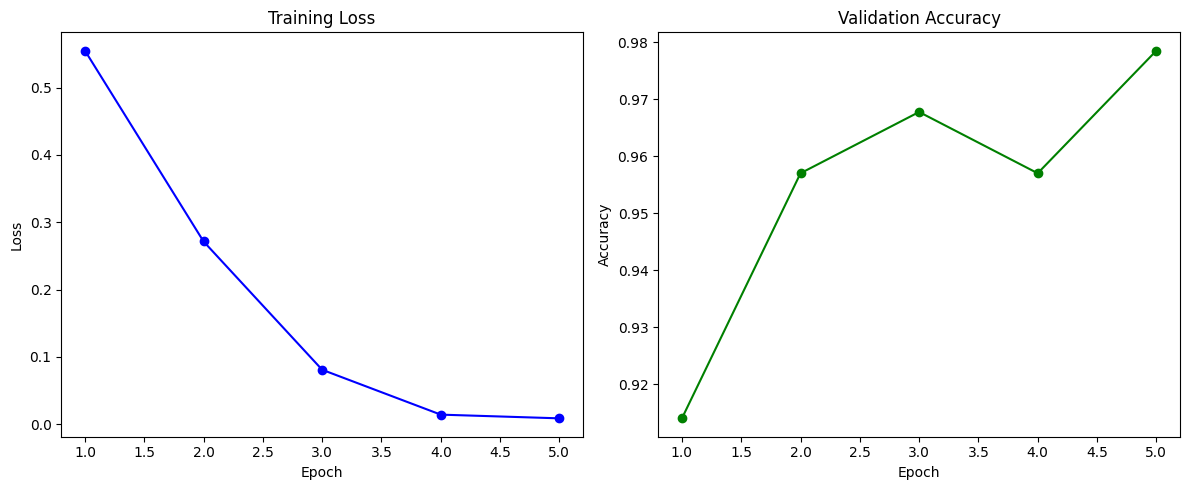

In [23]:
epochs = range(1, len(training_loss_list) + 1)

plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss_list, 'b-o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, validation_accuracy_list, 'g-o')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim(0.90, 1.00)  # Set Y-axis from 0.90 to 1.00

plt.tight_layout()
plt.show()


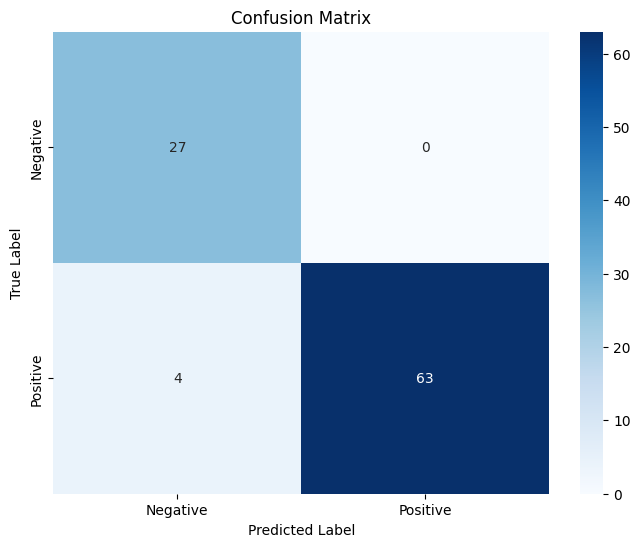

In [26]:
# Evaluate on test set
model.eval()

test_preds = []
test_labels = []

with torch.no_grad():
  for batch in DataLoader(TensorDataset(test_seq, test_mask, test_y), batch_size=batch_size, sampler=SequentialSampler(TensorDataset(test_seq, test_mask, test_y))):
    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch

    outputs = model(sent_id, attention_mask=mask)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)

    test_preds.extend(preds.cpu().numpy())
    test_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [27]:
# Load best model
model.load_state_dict(torch.load('best_bert_model.pt'))
model.eval()

# Gather predictions & true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_dataloader:
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        outputs = model(sent_id, attention_mask=mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 🧾 Print classification report
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print(f"\nBest Validation Accuracy: {best_val_accuracy:.4f}\n")
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive'], digits=4))


Best Validation Accuracy: 0.9785

Classification Report:

              precision    recall  f1-score   support

    Negative     0.9286    1.0000    0.9630        26
    Positive     1.0000    0.9701    0.9848        67

    accuracy                         0.9785        93
   macro avg     0.9643    0.9851    0.9739        93
weighted avg     0.9800    0.9785    0.9787        93

